Transfer Learning with a CNN


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory


%matplotlib inline

cudnn.benchmark = True
plt.ion()   # interactive mode

### Faster GPUs

In [17]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov 29 00:14:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   38C    P8              16W /  72W |      4MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### More memory

In [18]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


In [19]:
# !git clone https://github.com/sgeinitz/CS3120.git
!git clone https://github.com/jyassien/LPDI.git

fatal: destination path 'LPDI' already exists and is not an empty directory.


Load Data
=========

torchvision and torch.utils.data packages for loading the
data.



NOTE:  `batch_size`


In [21]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/LPDI/server/data_sample/tomato/Variant_A'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# check for a GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
# check for an Apple MPS device
elif torch.backends.mps.is_available():
    device = torch.device("mps")
# otherwise use the CPU
else:
    device = torch.device("cpu")

# print out which device is being used
print(f"Using device: {device}")

Using device: cuda:0


Examine a few Images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.

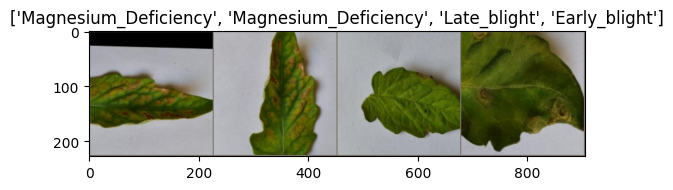

In [22]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
==================

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    b_losses = {'train':[], 'val':[]}
    e_losses = {'train':[], 'val':[]}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}', end="")

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    b_losses[phase].append(loss.item())

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                # print loss and accuraacy every 4 epochs
                if epoch % 4 == 0:
                    print(f'\t{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}', end="\t")
                   # print('-' * 10)
                # save loss for plotting later on
                e_losses[phase].append(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, e_losses, b_losses

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [24]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Approach A: Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.

This is also where we create instances of the `optimizer` and `scheduler` objects, both of which are then passed into
the `train_model` function as parameters.

In [25]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

print(f'Original number of input and output features of resnet18 : {model_ft.fc}')

# Here the size of each output sample is set to 2.
# In general, this could be written as ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 5)

print(f'Updated number of input and output features of resnet18 :  {model_ft.fc}')


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Original number of input and output features of resnet18 : Linear(in_features=512, out_features=1000, bias=True)
Updated number of input and output features of resnet18 :  Linear(in_features=512, out_features=5, bias=True)


Train and evaluate
==================

This will take 1-2 minutes on a GPU, or around 20-25 minutes with a CPU.


In [26]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,   num_epochs=25)

In [27]:
model_ft, epoch_losses, batch_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 1/25	train Loss: 1.6713 Acc: 0.2800		val Loss: 1.4827 Acc: 0.4200	
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25	train Loss: 0.8692 Acc: 0.7000		val Loss: 1.3761 Acc: 0.4800	
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25	train Loss: 0.4595 Acc: 0.8600		val Loss: 1.2893 Acc: 0.5000	
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25	train Loss: 0.4933 Acc: 0.8200		val Loss: 1.2786 Acc: 0.5400	
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25	train Loss: 0.3050 Acc: 0.9400		val Loss: 1.3817 Acc: 0.5200	
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25	train Loss: 0.5763 Acc: 0.8200		val Loss: 1.4433 Acc: 0.4800	
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25	train Loss: 0.3549 Acc: 0.9000		val Loss: 1.3898 Acc: 0.4800	
Training complete in 0m 16s
Best val Acc: 0.560000


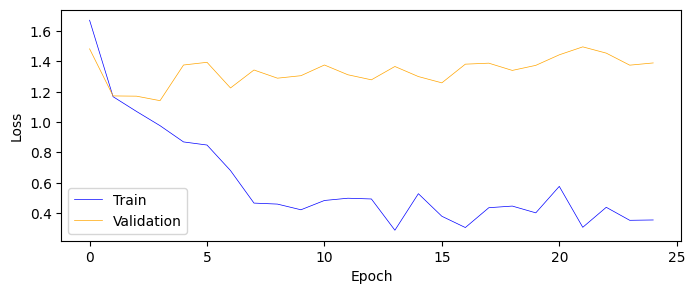

In [28]:
# plot the loss curves
plt.figure(figsize=(8, 3))
plt.plot(range(len(epoch_losses['train'])), epoch_losses['train'], c='blue', linewidth=0.5)
plt.plot(range(len(epoch_losses['val'])), epoch_losses['val'], c='orange', linewidth=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(('Train','Validation'))

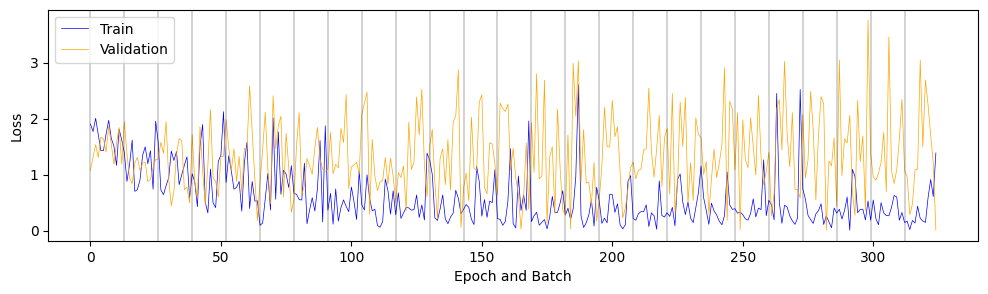

In [29]:
# plot the loss curves for each (mini) batch
plt.figure(figsize=(12, 3))
val_ticks = [(i)*len(batch_losses['train'])/len(batch_losses['val']) for i in range(len(batch_losses['val']))]
plt.plot(range(len(batch_losses['train'])), batch_losses['train'], c='blue', linewidth=0.5)
plt.plot(val_ticks, batch_losses['val'], c='orange', linewidth=0.5)
for i in range(25):
    plt.axvline(x=i*len(batch_losses['train'])/25, c='black', lw=0.25)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

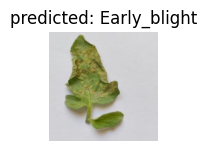

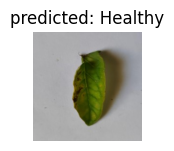

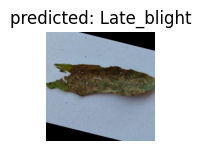

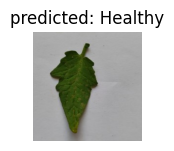

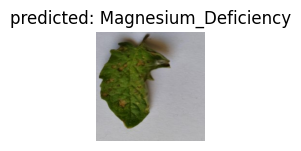

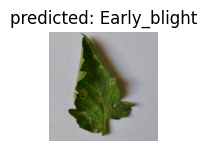

In [30]:
visualize_model(model_ft)

Approach B: ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [31]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
==================    


In [32]:
model_conv, epoch_losses, batch_losses = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 1/25	train Loss: 1.6845 Acc: 0.2000		val Loss: 1.5379 Acc: 0.3600	
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25	train Loss: 0.8995 Acc: 0.6200		val Loss: 1.1837 Acc: 0.5600	
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25	train Loss: 0.7417 Acc: 0.7600		val Loss: 1.1258 Acc: 0.5600	
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25	train Loss: 0.7371 Acc: 0.7800		val Loss: 1.1574 Acc: 0.6000	
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25	train Loss: 0.6280 Acc: 0.9200		val Loss: 1.1596 Acc: 0.5800	
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25	train Loss: 0.5846 Acc: 0.8600		val Loss: 1.1344 Acc: 0.5600	
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25	train Loss: 0.8054 Acc: 0.8000		val Loss: 1.0820 Acc: 0.6200	
Training complete in 0m 11s
Best val Acc: 0.640000


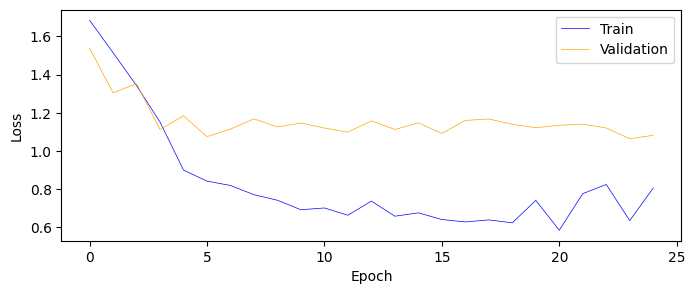

In [33]:
# plot the loss curves
plt.figure(figsize=(8, 3))
plt.plot(range(len(epoch_losses['train'])), epoch_losses['train'], c='blue', linewidth=0.5)
plt.plot(range(len(epoch_losses['val'])), epoch_losses['val'], c='orange', linewidth=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(('Train','Validation'))

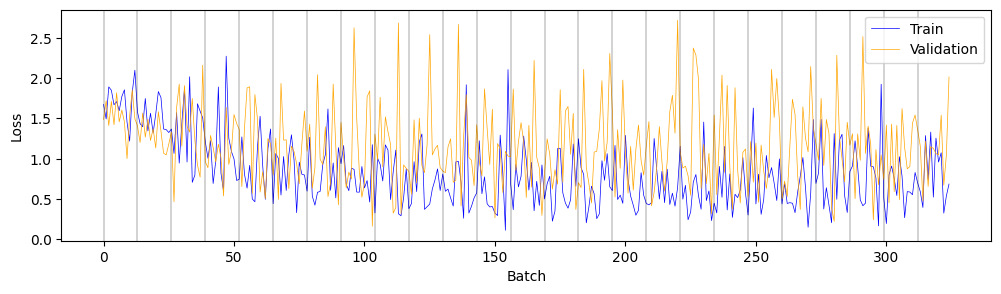

In [34]:
# plot the loss curves for each (mini) batch
plt.figure(figsize=(12, 3))
val_ticks = [(i)*len(batch_losses['train'])/len(batch_losses['val']) for i in range(len(batch_losses['val']))]
plt.plot(range(len(batch_losses['train'])), batch_losses['train'], c='blue', linewidth=0.5)
plt.plot(val_ticks, batch_losses['val'], c='orange', linewidth=0.5)
for i in range(25):
    plt.axvline(x=i*len(batch_losses['train'])/25, c='black', lw=0.25)
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.legend(('Train','Validation'))

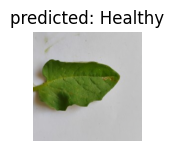

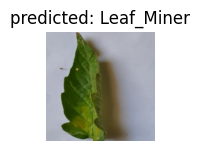

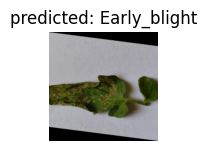

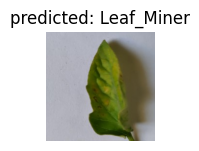

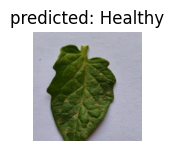

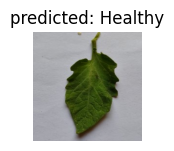

In [35]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Inference on one Images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [36]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

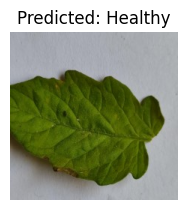

In [37]:
visualize_model_predictions(
    model_conv,
    img_path='/content/LPDI/server/data_sample/tomato/Variant_A/test/Late_blight/IMG20220323110731_4.jpg'
)

plt.ioff()
plt.show()